In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
#using Plots
using LaTeXStrings
using Optim
using ForwardDiff
import YAML
using Markdown
using Printf
using StaticArrays

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
#python stuff
using PythonCall
mpl=pyimport("matplotlib")
#mpl.use("Agg")
mpl.use("svg")
#mpl.use("module://juliacall.matplotlib") #some workaround for inline plotting
plt=pyimport("matplotlib.pyplot")

Python module: <module 'matplotlib.pyplot' from '/Users/huntemann/SeaIceThickness_ATBD/sit_atbd_env_jl/.CondaPkg/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [3]:
I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])


#reading fit parameters from file

fI(x)=I(pI)(x)
fQ(x)=Q(pQ)(x)

params=YAML.load_file("fit_params.yml")
const tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])


ff(p)=return f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

Fw_TB(x,p)=SA[ff(p[1])(x), ff(p[2])(x)]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

Fw_TB(x)=Fw_TB(x[1],(tbh_params,tbv_params))

Fw_TB (generic function with 2 methods)

In [4]:
function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    iSa=inv(Sa)
    iSe=inv(Se)
    χ²(y,x,iSe,iSa,xa,F)=(y.-F(x))'*(iSe*(y.-F(x)))+(xa.-x)'*(iSa*(xa.-x))
   if length(xa)==0
        xi=[maximize(x->-χ²(Ta,x,iSe,iSa,xa,F),0,10000).res.minimizer]
    else
        res=optimize(x->χ²(Ta,x,iSe,iSa,xa,F),xa)
        xi=res.minimizer
    end
#    @show χ²(Ta,y,Se,Sa,xa)
    M=ForwardDiff.jacobian(F,xi)
    xerr=inv(iSa+M'*iSe*M)
#    @show χ²(Ta,xi,iSe,iSa,xa,F)
    return xi[1],xerr[1]
end
    


retrieval(h,v)=retrieval([h,v],[25 15;15 25.0],fill(20000.,1,1),[100.],Fw_TB)


retrieval (generic function with 2 methods)

In [5]:
function lm_retrieval(Ta,Sₑ,Sₐ,xₐ,F)
    #lm method after Rodgers 2000
    #target: find x so that F(x)=Ta, given
    #Ta: measurement vector
    #Sₑ: error covariance of measurement
    #Sₐ: error covariance of physical state 
    #xₐ: expected physical state (also used as start, i.e. first guess)
    #F: the forward model translating measument space into state space
    Sₐ⁻¹=inv(Sₐ)
    Sₑ⁻¹=inv(Sₑ)
    #function to minimize with changing input x
    J(y,x,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)=(y.-F(x))'*(Sₑ⁻¹*(y.-F(x)))+(xₐ.-x)'*(Sₐ⁻¹*(xₐ.-x)) #first two temrs of eq 5.3
    xᵢ=copy(xₐ)
    Jᵢ=J(Ta,xᵢ,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
    γ=1e-5 #set to 0 for gauss newton
    for i=1:2000
        Kᵢ=ForwardDiff.jacobian(F,xᵢ)
        Ŝ⁻¹=Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ #eq 5.13
        xᵢ₊₁=xᵢ+((1+γ)*Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ)\(Kᵢ'*Sₑ⁻¹*(Ta-F(xᵢ))-Sₐ⁻¹*(xᵢ-xₐ)) #eq 5.36
        Jᵢ₊₁=J(Ta,xᵢ₊₁,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
        d²=(xᵢ-xᵢ₊₁)'*Ŝ⁻¹*(xᵢ-xᵢ₊₁) #eq 5.29
        if Jᵢ₊₁<Jᵢ #accepting & rejecting criterion from our local OEM
            γ/=2
        else
            γ*=10
            continue
        end
        xᵢ=xᵢ₊₁
        if d²<1e-10
            break
        end
        Jᵢ=Jᵢ₊₁
    end
    Kᵢ=ForwardDiff.jacobian(F,xᵢ)
    Ŝ=inv(Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ) # eq 5.38
    
    return xᵢ,Ŝ
end


retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 23;23 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))

retrievallm (generic function with 1 method)

In [6]:
retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 23;23 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))


retrievallm (generic function with 1 method)

In [7]:
using BenchmarkTools
using ProfileSVG

In [8]:
@btime retrievallm(200,250)

  1.067 μs (0 allocations: 0 bytes)


(37.520349738165486, 6.233193133148001)

In [9]:
cost(II,QQ)=f(x)=(fI(x)-II)^2+(fQ(x)-QQ)^2
retrieval_hun(ii,qq)=maximize(x->-cost(ii,qq)(x),0,200).res.minimizer 

retrieval_hun (generic function with 1 method)

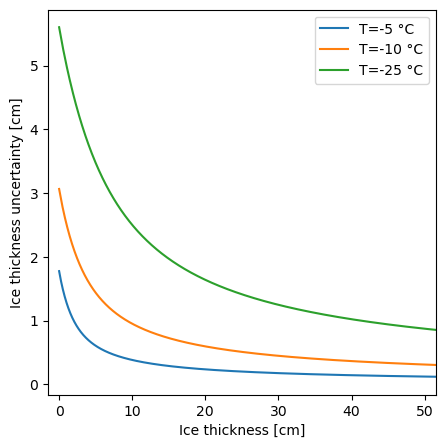

In [10]:
cfdd(temp,duration)=1.33*(-(temp+1.8)*duration)^0.58

days=0:0.01:200

max_ig(T,t)=cfdd(T,t+1)-cfdd(T,t-0)
sittime(sit,temp)=(1/(sit*1.33*(-temp+1.8)))^(1/0.58)
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)

for temp in [-5,-10,-25]    
    ax.plot(cfdd.(temp,days),max_ig.((temp,),days)*0.68,label="T=$temp °C")
end
ax.legend()
ax.set_xlim(-1.5,51.5)
ax.set_xlabel("Ice thickness [cm]")
ax.set_ylabel("Ice thickness uncertainty [cm]")

#plt.show();
display(fig)

In [11]:

function owerr(x) #original open water error
    owtbh=65
    owtbv=155
    owi=owtbv/2+owtbh/2
    owq=owtbv-owtbh
    owf=-0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_minus=retrieval_hun(I,Q)
    owf=0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_plus=retrieval_hun(I,Q)
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end
#ff2_p= [100.2,234.1,12.7]
#qparams = [51.0, 19.4, 31.8, 1.65]  # HBparams


function owerr_2(x,tbs=nothing) #new openwater error
    if tbs==nothing
        tbh,tbv=Fw_TB(x)
    else
        tbh,tbv=tbs
    end
    owtbh=67.7
    owtbv=148.9
    owf=-0.05
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    owf=0.05
    sit_minus=retrieval(ntbh,ntbv)[1]
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    sit_plus=retrieval(ntbh,ntbv)[1]
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end


function retrerr(x,ra)
    IR=fI(x)
    QR=fQ(x)
    ixmax=retrieval_hun(IR+ra*sqrt(2)/2,QR)
    ixmin=retrieval_hun(IR-ra*sqrt(2)/2,QR)
    qxmax=retrieval_hun(IR,QR+ra*sqrt(2))
    qxmin=retrieval_hun(IR,QR-ra*sqrt(2))
    (maximum(x.-[ixmax,ixmin])^2+maximum(x.-[qxmax,qxmin])^2)^0.5
end

sittime(sit,temp)=-(max(0,sit)/1.33)^(1/0.58)/(temp+1.8)

function cfdd_unc(sit)
    t=sittime(sit,-25)
    return (cfdd(-25,t+1)-cfdd(-25,t))*0.68
end

function comb_error(sit)
    return sqrt(cfdd_unc(sit)^2+retrerr(sit,5)^2+owerr(sit)^2)
end

function comb_error_2(sit)
    return sqrt(cfdd_unc(sit)^2+retrieval(Fw_TB(sit)...)[2]+owerr_2(sit)^2)
end

function comb_error_2(sit,tbh,tbv)
    return sqrt(cfdd_unc(sit)^2+retrieval(tbh,tbv)[2]+owerr_2(sit,(tbh,tbv))^2)
end

comb_error_2 (generic function with 2 methods)

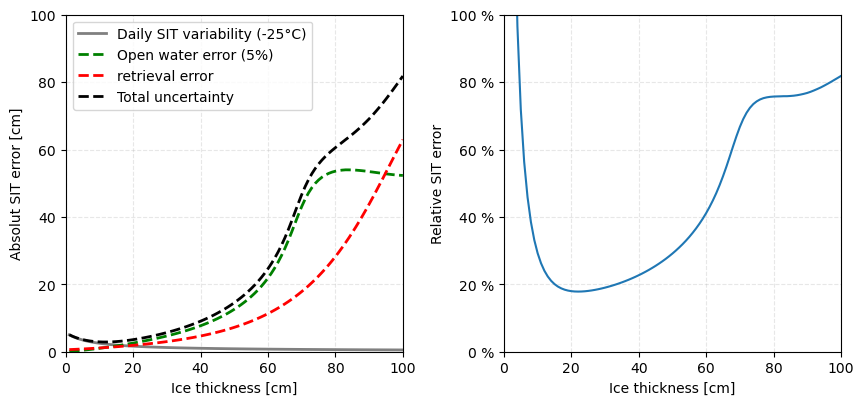

In [12]:
sit=1:100

fig2=plt.figure(figsize=[10,5])#,constrained_layout=true);
ax1=fig2.add_subplot(121);

ax1.plot(sit,cfdd_unc.(sit),label="Daily SIT variability (-25°C)",lw=2,c="gray");

ax1.plot(sit,owerr_2.(sit),label="Open water error (5%)",lw=2,ls="--",c="green");
ax1.plot(sit,[retrieval(Fw_TB(s)...)[2]^0.5 for s in sit],label="retrieval error",lw=2,ls="--",c="red");
ax1.plot(sit,comb_error_2.(sit),label="Total uncertainty",lw=2,ls="--",c="black");
ax1.set_aspect("equal", adjustable="box")

ax1.legend()
ax1.set_xlim(0,sit.stop)
ax1.set_ylim(0,sit.stop)
ax1.set_xlabel("Ice thickness [cm]")
ax1.set_ylabel("Absolut SIT error [cm]")
ax1.grid(linestyle="--",alpha=0.3)

ax2=fig2.add_subplot(122)
ax2.plot(sit,comb_error_2.(sit)./sit.*100);
ax2.set_ylim(0,100)
ax2.set_xlim(0,100)

ticks=0:20:100
ax2.set_yticks(ticks,[(@sprintf "%i %%" i) for i in ticks])
ax2.set_ylabel("Relative SIT error")
ax2.set_xlabel("Ice thickness [cm]")
ax2.set_aspect("equal", adjustable="box")
ax2.grid(linestyle="--",alpha=0.3)

fig2.subplots_adjust(wspace=0.3);

display(fig2)

In [13]:
Qs=20:90
Is=100:270
out=[retrievallm(ii-qq/2,ii+qq/2)[1] for ii=Is,qq=Qs]
out_err=[retrievallm(ii-qq/2,ii+qq/2)[2] for ii=Is,qq=Qs]
out_orig=[retrieval_hun(ii,qq) for ii=Is,qq=Qs];

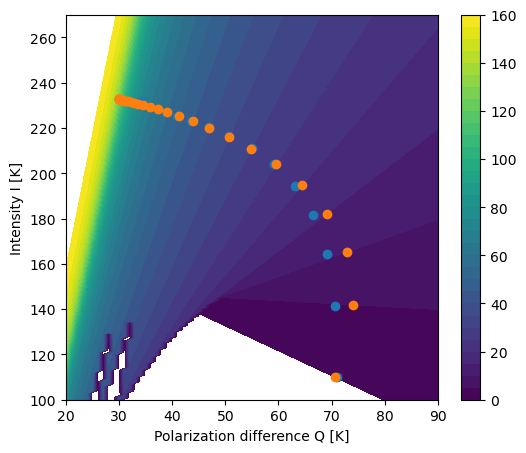

In [14]:

fig3=plt.figure(figsize=[6,5])
ax=fig3.add_subplot(111)
sit=0:5:160

im=ax.contourf(Qs,Is,out.-0.01,levels=sit)

h,v=sit_h.(sit),sit_v.(sit)
allq,alli=v.-h,h./2 .+v./2

ax.plot(fQ.(sit),fI.(sit),lw=0,marker="o",label="I-Q LstSQ")
ax.plot(allq,alli,lw=0,marker="o",label="H-V LstSQ")

ax.set_xlabel("Polarization difference Q [K]")
ax.set_ylabel("Intensity I [K]")

fig3.colorbar(im)

#plt.show(format="png")
display(fig3)